# Electrical Thermal Response Test (E-TRT) : Field Data - Varennes, Canada

This notebook processes the field data collected during the E-TRT experiment performed in Varennes, Canada, in October 2024. The SCW is 215 m deep, with a diameter of 165 mm. An injection well is located at a 10 m distance and is used to deviate bleed water.
The thermal response test (TRT) consisted in a 48-hour recirculation phase to homogenize the temperature in the borehole, followed by an 10-day heating phase, a bleed phase and a final 5-day restitution phase.

The usual TRT data was collected, including inlet and outlet temperatures and recirculation flow rates. The E-TRT adds temperature measurements along the SCW using distributed temperature sensing (DTS), water electrical measurements with a DTS probe and electrical resistivity measurement at the instrumented depth of the cable. For this survey, the instrumented part of the cable is composed of 32 electrodes spaced by 25 cm, located at a 150 m depth.

This notebook contains the following sections:
1. Thermal Response Test data
2. Distributed temperature sensing data
3. Water electrical conductivity measurements
4. Electrical data

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import scipy as sc

In [3]:
plt.rcParams.update({'font.size': 9,'axes.labelsize': 8,'xtick.labelsize': 8,'ytick.labelsize': 8,'legend.fontsize': 8,'figure.titlesize': 9})

In [4]:
dir_exp = '02-Varennes_data/01-Field_data/'

# 1.Thermal response test data

The data from measured by the TRT unit is imported.

In [5]:
dir_TRT = os.path.join(dir_exp, '01-Thermal_Response_Test/')

We start with the inlet and outlet temperatures and keep the data during the experiment.

In [6]:
# Import and load data
TA_file = os.path.join(dir_TRT, 'TA_geo_1030-2.csv')        
TR_file = os.path.join(dir_TRT, 'TR_geo_1030-2.csv')

TA_open = pd.read_csv(TA_file, delim_whitespace=True, skiprows=2, header=None, names=['1', '2', 'data', 'PanelDate', 'PanelTime', '6', '7'])
TA_data = np.array([float(s) for s in TA_open['data'][:-1]])
TR_open = pd.read_csv(TR_file, delim_whitespace=True, skiprows=2, header=None, names=['1', '2', 'data', 'PanelDate', 'PanelTime', '6', '7'])
TR_data = np.array([float(s) for s in TR_open['data'][:-1]])

In [7]:
# Extract time and filter
Date = pd.to_datetime(TA_open['PanelDate'][:-1], format='%Y-%m-%d')
Time = pd.to_datetime(TA_open['PanelTime'][:-1], format='%H:%M:%S.%f')
Datetime1 = Date + (Time - Time.dt.normalize())
filter1 = Datetime1 >= pd.to_datetime('2024-10-15 05:00:00')
filter2 = Datetime1 <= pd.to_datetime('2024-10-30 10:00:00')
date_filter1 = filter1 & filter2

# Keep the data during the experiment
Datetime1 = Datetime1[date_filter1]
TR = TR_data[date_filter1]  #degC
TA = TA_data[date_filter1]  #degC

Next, we import the flow rate data from the two flow meters (SCW and injection well) and keep the data during the experiment.

In [8]:
# Import and load data
V_geo_file = os.path.join(dir_TRT, 'abs_flow_geo_1030.csv')
V_saig_file = os.path.join(dir_TRT, 'abs_flow_saig_1030.csv')

V_geo_open = pd.read_csv(V_geo_file, delim_whitespace=True, skiprows=2, header=None, names=['1', '2', 'data', 'PanelDate', 'PanelTime', '6', '7'])
V_geo_data = np.array([float(s) for s in V_geo_open['data'][:-1]])
V_saig_open = pd.read_csv(V_saig_file, delim_whitespace=True, skiprows=2, header=None, names=['1', '2', 'data', 'PanelDate', 'PanelTime', '6', '7'])
V_saig_data = np.array([float(s) for s in V_saig_open['data'][:-1]])

In [9]:
# Extract time and filter
Date = pd.to_datetime(V_geo_open['PanelDate'][:-1], format='%Y-%m-%d')
Time = pd.to_datetime(V_geo_open['PanelTime'][:-1], format='%H:%M:%S.%f')
Datetime = Date + (Time - Time.dt.normalize())
filter1 = Datetime >= pd.to_datetime('2024-10-15 05:00:00')
filter2 = Datetime <= pd.to_datetime('2024-10-30 10:00:00')
date_filter = filter1 & filter2

# Keep the data during the experiment
Datetime = Datetime[date_filter]
V_geo = V_geo_data[date_filter] # L/sec
V_saig = V_saig_data[date_filter] # L/sec

Now we calculate the heating power using
$$
\Delta T = T_{in}-T_{out}\\
Q = \Delta T \dot{V}(\rho C_p)_w,
$$ where EWT is the entering water temperature, LWT is the leaving water temperature, $\dot{V}$ is the pumping rate and $(\rho C_p)_w$ is the water volumetric heat capacity.

In [10]:
Q = (V_geo * 0.001) * (4200 * 1000) * - (TA - TR) # W

The TRT data can now be visualized.

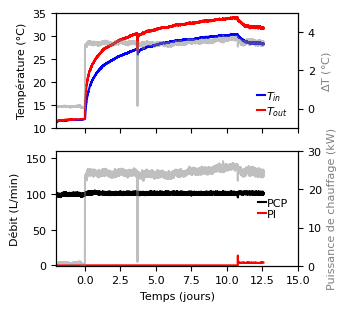

In [11]:
time = (pd.to_datetime(Datetime)-datetime.datetime(2024, 10, 17, 16, 10) -  datetime.timedelta(hours=4)).dt.total_seconds()/3600/24

fig, ax = plt.subplots(2, 1, figsize=(9/2.54, 8/2.54), sharex=True)

ax[0].plot(time, TA, 'blue', label = '$T_{in}$')
ax[0].plot(time, TR, 'red', label = '$T_{out}$')
ax[0].set_ylabel('Temperature (°C)')
ax[0].set_ylabel('Température (°C)')
ax[0].set_ylim(10, 35)
ax[0].set_xlim(-2, 15)
#plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d'))
ax2= ax[0].twinx()
ax2.plot(time, TR-TA, 'grey', alpha = 0.5)
ax2.set_ylabel('$\Delta$T (°C)', color='grey')
ax2.set_ylim(-1, 5)

ax[1].plot(time, V_geo * 60, label='PCP', color='black')
ax[1].plot(time, V_saig * 60, label='PI', color='red')
ax3 = ax[1].twinx()
ax3.plot(time, Q/1000, 'grey', alpha = 0.5)
ax3.set_ylabel('Puissance de chauffage (kW)', color='grey')
ax3.set_ylim(0,30)

ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Flow rate (L/min)')
ax[1].set_xlabel('Temps (jours)')
ax[1].set_ylabel('Débit (L/min)')
ax[1].set_ylim(-0.5, 160)

ax[0].legend(fontsize=8, ncol=1, frameon=False,  handlelength=0.7, handletextpad=0.1, labelspacing=0.1, loc='lower right')
ax[1].legend(fontsize=8, frameon=False, ncol=1, handlelength=0.7, handletextpad=0.1, labelspacing=0.1, loc='center right')

plt.tight_layout()

We apply a temperature correction based on the undisturbed temperature before heating starts, for which the difference between TR and TA should be zero.

In [12]:
i_dT = next((i for i, dt in enumerate(Datetime1) if dt > pd.to_datetime('2024-10-17 20:00:00')), None)
i_dT2 = next((i for i, dt in enumerate(Datetime1) if dt > pd.to_datetime('2024-10-17 20:30:00')), None)
dT_cor = np.mean(TR[i_dT:i_dT2]-TA[i_dT:i_dT2])
print('Correction on dT', dT_cor, '°C')

# Caculate heating power with temperature correction
Q_cor = (V_geo * 0.001) * (4200 * 1000) * (TR - TA - dT_cor)  # W

Correction on dT 0.05435921351116656 °C


The TRT data is saved.

In [13]:
data_trt = pd.DataFrame({'datetime': Datetime, 'time (s)': time/3600/24, 'T_in (degC)': TA, 'T_out (degC)': TR, 'V_geo (L/s)': V_geo, 'V_saig (L/s)': V_saig, 'Q (W)': Q_cor})
data_trt.to_csv(os.path.join(dir_exp, 'data_TRT.csv'), index=False)

For the E-TRT, we need the heating power during the heating period only.
The heating started on 17th October 2024 at 16:30 and ended on 28th October 2024 at 09:00. For this dataset, there is a 4 hour difference between the local time and measured time.

In [14]:
start_heating = datetime.datetime(2024, 10, 17, 16, 30)
delay_trt = datetime.timedelta(hours=4)
i_start = next((i for i, dt in enumerate(Datetime) if dt > pd.to_datetime('2024-10-17 20:30:00')), None)
i_end = next((i for i, dt in enumerate(Datetime) if dt > pd.to_datetime('2024-10-28 13:00:00')), None)

TR_heating = TR[i_start:i_end]
TA_heating = TA[i_start:i_end]
T_heating = (TR_heating + TA_heating)/2
V_heating = V_geo[i_start:i_end]

Datetime_heating = Datetime[i_start:i_end]
Q_heating = Q_cor[i_start:i_end]

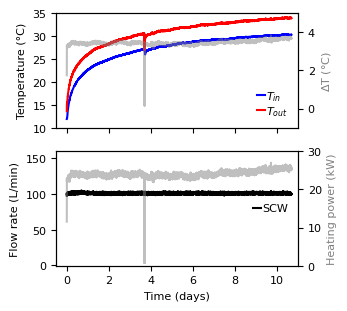

In [15]:
time = (pd.to_datetime(Datetime_heating) - start_heating - delay_trt).dt.total_seconds()/3600/24 

fig, ax = plt.subplots(2, 1, figsize=(9/2.54, 8/2.54), sharex=True)

ax[0].plot(time, TA_heating, 'blue', label = '$T_{in}$')
ax[0].plot(time, TR_heating, 'red', label = '$T_{out}$')
ax[0].set_ylabel('Temperature (°C)')
ax[0].set_ylim(10, 35)
ax[0].set_xlim(-0.5, 11)

ax2= ax[0].twinx()
ax2.plot(time, TR_heating-TA_heating, 'grey', alpha = 0.5)
ax2.set_ylabel('$\Delta$T (°C)', color='grey')
ax2.set_ylim(-1, 5)

ax[1].plot(time, V_heating * 60, label='SCW', color='black')
ax3 = ax[1].twinx()
ax3.plot(time, Q_heating/1000, 'grey', alpha = 0.5)
ax3.set_ylabel('Heating power (kW)', color='grey')
ax3.set_ylim(0,30)

ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Flow rate (L/min)')

ax[1].set_ylim(-0.5, 160)


ax[0].legend(fontsize=8, ncol=1, frameon=False,  handlelength=0.7, handletextpad=0.1, labelspacing=0.1, loc='lower right')
ax[1].legend(fontsize=8, frameon=False, ncol=1, handlelength=0.7, handletextpad=0.1, labelspacing=0.1, loc='center right')

plt.tight_layout()

In [16]:
print('Average heat rate (W)', np.average(Q_heating))
print('std of heat rate (W)', np.std(Q_heating))
print('Average flow rate during heating (L/s) ', np.average(V_heating))
print('std of heat rate (L/s)', np.std(V_heating))

Average heat rate (W) 24038.667747973064
std of heat rate (W) 1207.640232337084
Average flow rate during heating (L/s)  1.6840380764224454
std of heat rate (L/s) 0.0146392949057603


We save the heating power during heating.

In [17]:
np.save(os.path.join(dir_exp, 'Q_heating.npy'), Q_heating)

# 2. Distributed temperature sensing data

For the E-TRT, we need the temperature at the depth of the instrumented section of the multi-electrode cable. The latter is obtained from distributed temperature sensing (DTS) measurements along the optical fiber installed in the SCW.

The DTS data is imported.

In [18]:
# Load  DTS data

dir_dts = os.path.join(dir_exp, '02-Distributed_Temperature_Sensing/')
channel1_files = []

for root, dirs, files in os.walk(dir_dts):
    for filename in glob.glob(os.path.join(root, '*Channel_1*.csv')):
        channel1_files.append(filename)

channel1_files = sorted(channel1_files)

In [19]:
def Load_DTS(files):

    DATA = [None] * len(files)
    nb_var = np.zeros(len(files), dtype=int)
    z = [None] * len(files)
    t_TMP = [None] * len(files)
    t = []
    Tz = [None] * len(files)

    for ii in range(len(files)):
        DATA[ii] = pd.read_csv(files[ii], header=None, encoding='unicode_escape')
        nb_var[ii] = DATA[ii].shape[1]

        # Extract the depth
        z[ii] = DATA[ii].iloc[4:, 0].astype(float).to_numpy()

        # Extract the time 
        t_TMP[ii] = []
        for jj in range(nb_var[ii] - 1):
            time_str = f"{DATA[ii].iloc[0, jj + 1]} {DATA[ii].iloc[1, jj + 1]}"
            t_TMP[ii].append(time_str)
            t.append(datetime.datetime.strptime(t_TMP[ii][jj], '%d-%m-%Y %I:%M:%S %p'))

        # Extract the temperatures
        Tz[ii] = DATA[ii].iloc[4:, 1:].astype(float).to_numpy()

    T = np.concatenate(Tz, axis=1)
    z = z[0]  
    
    return t, z, T

t1, z1, T1 = Load_DTS(channel1_files)

## Depth correction

The DTS data position has to be corrected to match the reference of the borehole. This also allows to remove the portion of the data over the water table and locate the section of the fiber inside the calibration bath.

In [20]:
# define TRT period indices
i_undisturbed = next((i for i, dt in enumerate(t1) if dt > pd.to_datetime('2024-10-11 00:00:00')), None) # Time when there is no activity in the well
i_heating = next((i for i, dt in enumerate(t1) if dt > pd.to_datetime('2024-10-17 16:30:00')), None) # Time when heating starts

Text(0, 0.5, 'Temperature (°C)')

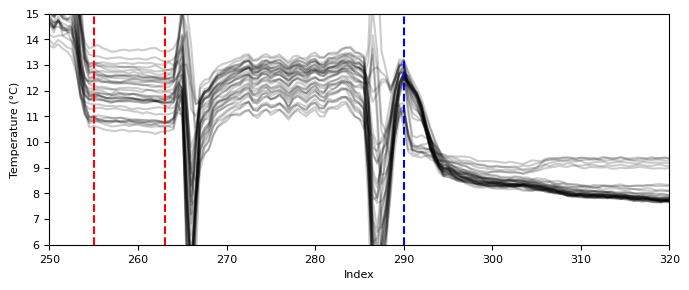

In [21]:
i_cal = [255, 263] # calibration bath index

plt.figure(figsize=(8, 3))

for i in range(i_undisturbed, i_heating, 50):
    plt.plot(z1, T1[:, i], color='black', alpha=0.2)
    
plt.ylim(6, 15)
plt.xlim(250, 320)
plt.axvline(x=290, color='blue', linestyle='--') # water table
plt.axvline(x=i_cal[0], color='red', linestyle='--') 
plt.axvline(x=i_cal[1], color='red', linestyle='--') 
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')

(6.0, 15.0)

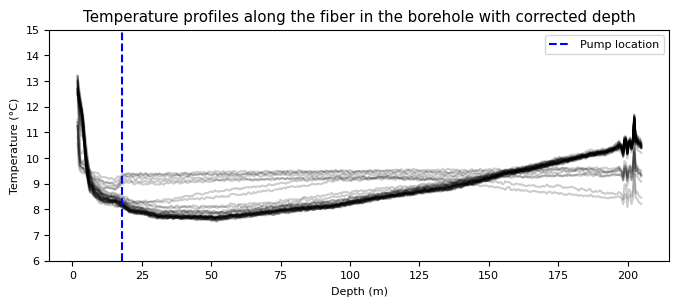

In [22]:
casing = 0.90 # m
water_table = 2.80 # m
fiber_water = 290 # m
remove_noise = 205 # m

i_water = np.where(z1 >= fiber_water)[0]
z = z1[i_water] - fiber_water + (water_table - casing)
i_noise = np.where(z < remove_noise)[0]
z = z[i_noise]
T = T1[i_water[i_noise], :]

plt.figure(figsize=(8, 3))
plt.title('Temperature profiles along the fiber in the borehole with corrected depth')
for i in range(i_undisturbed, i_heating+10, 50):
    plt.plot(z, T[:, i], color='black', alpha=0.2)
plt.axvline(x=18, color='blue', linestyle='--', label='Pump location')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.ylim(6,15)

## Temperature calibration

The DTS data has to be calibrated against the temperature measured in the calibration bath.

The temperature data from the probe located inside the calibration bath is loaded.

In [23]:
data_Tcal = pd.read_csv(os.path.join(dir_dts, 'HOBO_T_cal_fibre.csv'), skiprows=1)

data_Tcal.rename(columns={data_Tcal.columns[1]: 'DateTime'}, inplace=True)
data_Tcal['DateTime'] = pd.to_datetime(data_Tcal['DateTime'], format='%m/%d/%y %I:%M:%S  %p')
data_Tcal.rename(columns={data_Tcal.columns[2]: 'Temperature'}, inplace=True)

In [24]:
# Keep only the data between 14/10 and 04/11 (experiment period)
data_Tcal = data_Tcal[(data_Tcal['DateTime'] >= pd.to_datetime('10-14-2024 13:00:00')) & (data_Tcal['DateTime'] <= pd.to_datetime('11-04-2024'))]

Now we interpolate the calibration bath data to match the DTS measurement times and calculate the temperature difference between the two datasets over the calibration bath section of the fiber.

In [25]:
i_cal_start = next((i for i, z in enumerate(z1) if z >= i_cal[0]), None) 
i_cal_end = next((i for i, z in enumerate(z1) if z >= i_cal[1]), None)

# Select datetime for both datasets
t1_datetime = pd.to_datetime(t1) # fiber
data_T_datetime = pd.to_datetime(data_Tcal['DateTime']) # probe

# Find the index of the first time both datasets start overlapping
start_index = np.searchsorted(t1_datetime, data_T_datetime.iloc[0]) 
t1_overlap = t1_datetime[start_index:]

# Keep the average DTS measures in the calibration bath
T1_overlap = np.mean(T1[i_cal_start:i_cal_end, start_index:], axis=0)

# Interpolate the probe data to match DTS times
T_cal_probe = np.interp(t1_overlap.astype(int), data_T_datetime.astype(int), data_Tcal['Temperature'])
T_diff = T1_overlap - T_cal_probe

A linear calibration trend is defined next.

-0.0005179879598740838 -1.9477878380444325


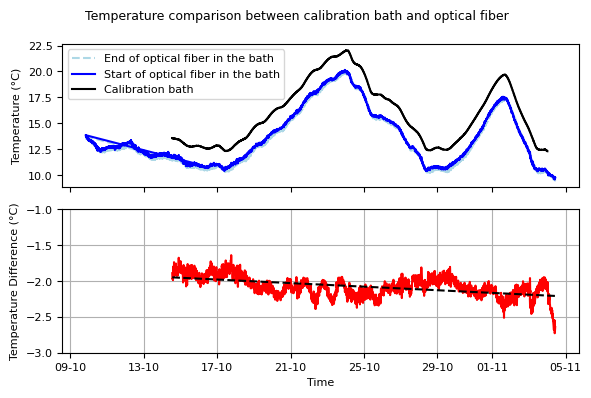

In [26]:
time_numeric = (t1_overlap - t1_overlap[0]).total_seconds() # seconds
slope, intercept, _, _, _ = sc.stats.linregress(time_numeric, T_diff)
cal_trend = slope * time_numeric + intercept
print(slope*3600, intercept)

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

plt.suptitle('Temperature comparison between calibration bath and optical fiber')

ax[0].plot(t1, T1[i_cal_end], '--',color='lightblue', label='End of optical fiber in the bath')
ax[0].plot(t1, T1[i_cal_start], color='blue', label='Start of optical fiber in the bath')
ax[0].plot(data_Tcal['DateTime'], data_Tcal['Temperature'], color='black', label='Calibration bath')
ax[0].legend()
ax[0].set_ylabel('Temperature (°C)')

ax[1].plot(t1_overlap, T_diff, color='red', label='Mean Difference (Overlapping Period)')
ax[1].plot(t1_overlap, cal_trend, color='black', linestyle='--', label=f'Linear Fit (Slope={slope:.2f})')
ax[1].set_ylabel('Temperature Difference (°C)')
ax[1].set_ylim(-3, -1)
ax[1].grid()
ax[1].set_xlabel('Time')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
plt.tight_layout()

Temperature differences between the calibration bath and the optical fiber are between 1.75 and 2.75°C. The difference is sinusoidal with a period of 24 hours with a general trend following the slope of the linear fit -0.0005°C/h. Applied temperature calibration is :
$$
T_{calibrated} = T_{fiber} + (1.95 °C + 0.0005 \times t(h))
$$

In [27]:
t_cal = t1_datetime[start_index:]
T_cal = T[:, start_index:]

dT = abs(intercept) + abs(slope*3600) * (t_cal - t_cal[0]).total_seconds() / 3600
T_cal = T_cal + dT.to_numpy()[np.newaxis, :]
T_cal1 = T1[i_cal_start:i_cal_end, start_index:] + dT.to_numpy()[np.newaxis, :]

We plot the calibrated DTS data.

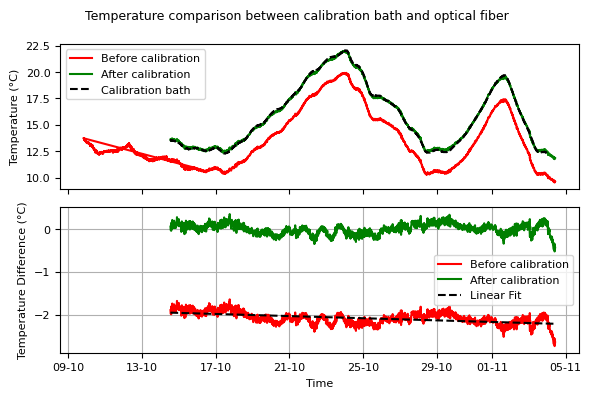

In [28]:
# Calibration index

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

plt.suptitle('Temperature comparison between calibration bath and optical fiber')

ax[0].plot(t1, np.mean(T1[i_cal_start:i_cal_end], axis=0), color='red', label='Before calibration')
ax[0].plot(t_cal, np.mean(T_cal1, axis=0), color='green', label='After calibration')
ax[0].plot(data_Tcal['DateTime'], data_Tcal['Temperature'], '--', color='black', label='Calibration bath')
ax[0].legend()
ax[0].set_ylabel('Temperature (°C)')

ax[1].plot(t1_overlap, T_diff, color='red', label='Before calibration')
ax[1].plot(t_cal, np.mean(T_cal1, axis=0) - T_cal_probe, color='green', label='After calibration')
ax[1].plot(t1_overlap, cal_trend, color='black', linestyle='--', label=f'Linear Fit')
ax[1].set_ylabel('Temperature Difference (°C)')
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Time')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
plt.tight_layout()

In [29]:
Tdelta = T_cal1 - T_cal_probe
print('Mean difference before and after calibration:', np.round(np.mean(abs(Tdelta)), 2), '°C')
print('Standard deviation before and after calibration:', np.round(np.std(abs(Tdelta)), 2), '°C')
print('Error containing 95% of the data:', np.round(np.percentile(abs(Tdelta), 95), 2), '°C')

Mean difference before and after calibration: 0.11 °C
Standard deviation before and after calibration: 0.08 °C
Error containing 95% of the data: 0.26 °C


We use $\sigma_T$ = 0.26 °C as the temperature measurement error for the DTS data after calibration.

## Select temperature at cable depth

Now the portion of the data corresponding to the cable section is extracted (150 to 158 m depth).

/tmp/ipykernel_8393/3186878978.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh((t_cal-start_heating).total_seconds(), z, T_cal, shading='auto', cmap='coolwarm')


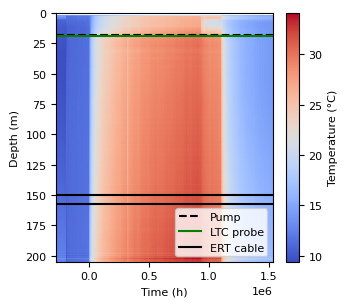

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(9/2.54, 8/2.54))

c = ax.pcolormesh((t_cal-start_heating).total_seconds(), z, T_cal, shading='auto', cmap='coolwarm')

cbar = plt.colorbar(c, ax=ax)
cbar.set_label('Temperature (°C)')

ax.set_ylabel('Depth (m)')
ax.set_xlabel('Time (h)')
ax.set_ylim(205, 0)
ax.axhline(y=18, color='black', linestyle='--', label='Pump')
ax.axhline(y=19, color='green', linestyle='-', label='LTC probe')
ax.axhline(y=150, color='black', linestyle='-', label='ERT cable')
ax.axhline(y=157.75, color='black', linestyle='-')
ax.legend(loc='lower right', borderpad=0.3)
plt.tight_layout()


The temperature between 150-158 m is selected and averaged.

In [31]:
# Find indices for the cable section
i_cable_start = next((i for i, dz in enumerate(z) if dz > 150), None)
i_cable_end = next((i for i, dz in enumerate(z) if dz > 158), None)
z_cable = z[i_cable_start:i_cable_end]
print('Temperature measure data point', z_cable, 'm')

Temperature measure data point [150.4 150.9 151.4 151.9 152.4 152.9 153.4 153.9 154.4 154.9 155.4 155.9
 156.4 156.9 157.4 157.9] m


In [32]:
T_avg_cable = np.mean(T_cal[i_cable_start:i_cable_end, :], axis=0)
DTS_full = pd.DataFrame({'datetime': t_cal, 'time (s)': (t_cal-start_heating).total_seconds(),'temperature (degC)': T_avg_cable})

Data during heating is selected for the E-TRT.

In [33]:
i_h1 = next((i for i, dt in enumerate(DTS_full['datetime']) if dt > pd.to_datetime('2024-10-17 16:30:00')), None)
i_h2 = next((i for i, dt in enumerate(DTS_full['datetime']) if dt > pd.to_datetime('2024-10-28 10:00:00')), None)
fiberH = DTS_full.iloc[i_h1:i_h2]

The undisturbed temperature before heating is also extracted for reference.

In [34]:
DTS_T0 = DTS_full.iloc[i_h1-50:i_h1-2]

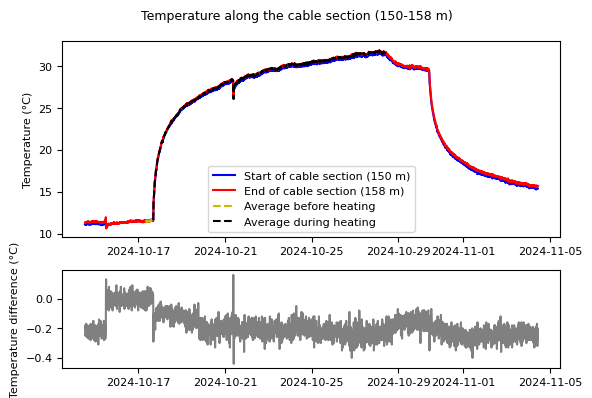

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), height_ratios=[2, 1])

plt.suptitle('Temperature along the cable section (150-158 m)')
ax[0].plot(t_cal, T_cal[i_cable_start, :], 'b-', label='Start of cable section (150 m)')
ax[0].plot(t_cal, T_cal[i_cable_end, :], 'r-', label='End of cable section (158 m)')
ax[0].plot(DTS_T0['datetime'], DTS_T0['temperature (degC)'], 'y--', label='Average before heating')
ax[0].plot(fiberH['datetime'], fiberH['temperature (degC)'], 'k--', label='Average during heating')
ax[0].set_ylabel('Temperature (°C)')
ax[0].legend()
ax[1].plot(t_cal, T_cal[i_cable_start, :]-T_cal[i_cable_end, :], 'grey')
ax[1].set_ylabel('Temperature difference (°C)')
#plt.plot(T_cal[i_cable_end, :])
plt.tight_layout()

In [36]:
print('Undisturbed temperature before heating at cable depth (°C):', DTS_T0['temperature (degC)'].mean())

Undisturbed temperature before heating at cable depth (°C): 11.516717236087723


We save the corresponding heating DTS data.

In [37]:
fiberH.to_csv(os.path.join(dir_exp, 'data_DTS_heating.csv'), index=False)

# 3. Water electrical conductivity measurements

A LTC probe was placed 1 m below the pump intake to measure the water electrical conductivity.

The data from the LTC probe is loaded.

In [38]:
LTC_file = os.path.join(dir_exp, '03-Electrical_conductivity_probe/LTC-water conductivity.csv')

LTC_data = pd.read_csv(LTC_file, skiprows=14, encoding='ISO-8859-1', names=['Date', 'Time','ms', 'lvl3', 'T', 'sigma_w'])
Datetime_LTC = pd.to_datetime(LTC_data['Date'] + ' ' + LTC_data['Time'], format='%Y-%m-%d %I:%M:%S %p')

The LTC probe was taken out of the twice times during the experiment. These periods are filtered out from the data.

In [39]:
# Filter the moment when the probe was taken out of the well
start_time1 = pd.Timestamp('2024-10-17 08:30:00')
end_time1 = pd.Timestamp('2024-10-17 15:00:00')
start_time2 = pd.Timestamp('2024-10-19 12:00:00')
end_time2 = pd.Timestamp('2024-10-21 12:00:00')
time_mask1 = (Datetime_LTC >= start_time1) & (Datetime_LTC <= end_time1)
time_mask2 = (Datetime_LTC >= start_time2) & (Datetime_LTC <= end_time2)
time_mask = time_mask1 | time_mask2

# Apply boolean mask
LTC_data_clean = LTC_data.loc[~time_mask]
Datetime_LTC_clean = Datetime_LTC.loc[~time_mask]

Water samples were taken from the field during the E-TRT. Their specific conductance was measured in the lab.

In [40]:
# Lab data is copied here
date_lab = "2024-10-15 11:00, 2024-10-15 14:00, 2024-10-18 09:00, 2024-10-21 09:00, 2024-10-23 09:00, 2024-10-25 09:00, 2024-10-28 10:00, 2024-10-28 11:30, 2024-10-30 09:45"
date_lab = date_lab.split(", ")
date_lab = [datetime.datetime.strptime(tt, "%Y-%m-%d %H:%M") for tt in date_lab]
t_lab = [(tt - datetime.datetime(2024, 10, 17, 16, 10)).total_seconds()   for tt in date_lab]  # Convert to days since start of TRT
rho_lab = [0.5251, 0.7095, 0.6741, 0.7031, 0.7349, 0.7672, 0.7939, 0.7765, 0.4170] # S/m at 25 degC

lab_cal = pd.DataFrame({'datetime': date_lab, 'time (s)': t_lab, 'sigma_w (S/m)': rho_lab})
lab_cal.to_csv(os.path.join(dir_exp, 'data_LTC_lab_measurements.csv'), index=False)

We compare them to the specific conductance measured with the LTC probe. The specific conductance $\sigma_s$ was calculated from the LTC data using this equation :

$$\sigma_s = \frac{\sigma_w}{1 + 0.02(T - 25)}$$

https://www.solinst.com/products/dataloggers-and-telemetry/3001-levelogger-series/operating-instructions/user-guide/1-introduction/1-2-4-conductivity.php

In [41]:
LTC_data_clean = LTC_data_clean.copy()
LTC_data_clean['sigma_s'] = LTC_data_clean['sigma_w'] / (1 + 0.02 * (LTC_data_clean['T'] - 25))

Plot LTC measurements and lab samples.

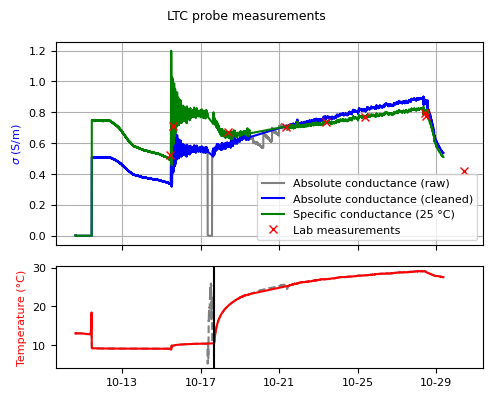

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(5, 4), sharex=True, height_ratios=[2, 1])

plt.suptitle('LTC probe measurements')

ax[0].plot(Datetime_LTC, LTC_data['sigma_w']/10000, label='Absolute conductance (raw)', color='grey')
ax[0].plot(Datetime_LTC_clean, LTC_data_clean['sigma_w']/10000, label='Absolute conductance (cleaned)', color='blue')
ax[0].plot(Datetime_LTC_clean, LTC_data_clean['sigma_s']/10000, label='Specific conductance (25 °C)', color='green')
ax[0].plot(lab_cal['datetime'], np.array(lab_cal['sigma_w (S/m)']),'x', label='Lab measurements', color='red')

ax[0].set_ylabel('$\sigma$ (S/m)', color='blue')
ax[0].legend()
ax[0].grid()

ax[1].plot(Datetime_LTC, LTC_data['T'], '--', label='Temperature', color='grey')
ax[1].plot(Datetime_LTC_clean, LTC_data_clean['T'], label='Temperature (cleaned)', color='red')
ax[1].axvline(start_heating, color='k')
ax[1].set_ylabel('Temperature (°C)', color='red')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d'))

plt.tight_layout()

Both specific conductance measured on samples in the lab and from continuous measurement with the LTC probe match well. This validates the LTC data.

Because the LTC data will be used for punctual ERT measurements, we apply a filter to obtain a smoother trend. We extract the data after the heating period and apply a variable window median to reduce noise.

In [43]:
# Filter the data after the start of heating
i_heating1 = pd.Timestamp('2024-10-17 16:30:00')

time_mask = (Datetime_LTC_clean >= i_heating1)
LTC = LTC_data_clean.loc[time_mask]
Datetime_LTC_clean = Datetime_LTC_clean.loc[time_mask]

In [44]:
# Apply a variable window median

Datetime_full = pd.date_range(start=Datetime_LTC.min(), end=Datetime_LTC.max(), freq=Datetime_LTC.diff().mode()[0])
LTC_full = pd.Series(LTC['sigma_w'].values, index=Datetime_LTC_clean).reindex(Datetime_full)

window_size = 200
LTC_full_interp = LTC_full.interpolate(method='linear')

def variable_window_median(series, max_window):
    result = series.copy()
    for i in range(len(series)):

        left_size = min(i, max_window//2)
        right_size = min(len(series)-i-1, max_window//2)
        
        window_start = i - left_size
        window_end = i + right_size + 1
        window_data = series.iloc[window_start:window_end].dropna()
        
        if len(window_data) > 0: 
            result.iloc[i] = window_data.median() 
        
        else: result.iloc[i] = np.nan

    
    return result

LTC_f = variable_window_median(LTC_full_interp, window_size)
time_LTC = (pd.to_datetime(Datetime_full) - start_heating).total_seconds() 

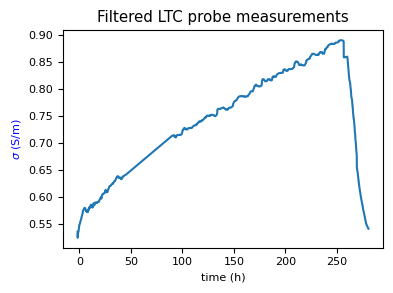

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))

ax.set_title('Filtered LTC probe measurements')
ax.plot(time_LTC/3600, LTC_f/10000)
ax.set_ylabel('$\sigma$ (S/m)', color='blue')
ax.set_xlabel('time (h)')

plt.tight_layout()

The resulting data is saved to use for the E-TRT inversion.

In [46]:
data_LTC = pd.DataFrame({'datetime': Datetime_full, 'time (s)': time_LTC, 'sigma_w (S/m)': LTC_f.values/10000})
data_LTC.to_csv(os.path.join(dir_exp, 'data_LTC_heating.csv'), index=False)

# 4. Electrical data

The electrical data was measured using a Pole-Pole geometry from a cable of 32 electrodes spaced by 25 cm between 150-157.75 m depth.

## Load electrical data during the heating phase

First, the ERT files are loaded during heating only, as this data will be used for the E-TRT inversion.

In [47]:
dir_ERT = '02-Varennes_data/01-Field_data/04-Electrical_data/'

In [48]:
subH = ['VARENNES-H1710', 'VARENNES-H1810', 'VARENNES-H1910', 'VARENNES-H2010', 'VARENNES-H2110', 'VARENNES-H2210', 'VARENNES-H2310', 'VARENNES-H2410', 'VARENNES-H2510', 'VARENNES-H2610', 'VARENNES-H2710', 'VARENNES-H2810']

def files_in_dir(dir_ERT, subC, pattern='_1'):
    all_files = []
    for sub in subC:
        sub_dir = os.path.join(dir_ERT, sub)
        if os.path.exists(sub_dir):
            files = [os.path.join(sub_dir, f) for f in os.listdir(sub_dir) if pattern in f]
            all_files.extend(files)
        else:
            print(f"Directory does not exist: {sub_dir}")
    return all_files

ert_files = files_in_dir(dir_ERT, subH)
print('Number of files:', len(ert_files))

Number of files: 99


The reference measure, without any thermal perturbation, at the end of recirculation is selected. 

In [49]:
file0 = os.path.join(dir_ERT, 'VARENNES-C1710/Varennes-C1710_T0.txt')
ert_files = [file0] + ert_files

The ERT data with respect to the position of the injection electrode is first filtered. For each injection position, the data for all the measurement electrodes along the cable is extracted, along with the spacing between active injection and potential electrode.


In [50]:
a_electrodes = [0, 1, 2, 3, 4, 5, 6, 7, 7.75] # position of injection electrodes along the cable

In [51]:
def extract_columns(file):
    specific_columns = ['A(x)', 'A(z)', 'A(adr)', 'B(x)', 'B(z)', 'N(x)', 'N(z)', 'M(x)', 'M(z)', 'M(adr)', 'U(V)', 'R(Ohm)', 'I(mA)',
                        'Rho-a(Ohm-m)', 'Var(%)', 'Time']
    df = pd.read_csv(file, sep='\t', index_col=False)
    extracted_df = df[specific_columns]
    return extracted_df

def filter_ERT_data(file):
    
    df = extract_columns(file)

    PPh = {'0': pd.DataFrame(), '1': pd.DataFrame(), '2': pd.DataFrame(), '3': pd.DataFrame(), '4': pd.DataFrame(), '5': pd.DataFrame(), '6': pd.DataFrame(), '7': pd.DataFrame(), '7.75': pd.DataFrame()}
    
    for _, i in enumerate(a_electrodes):
        PPh[f'{i}'] = df[(df['A(z)'] == i) & (df['B(z)'] == 0.0) & (df['N(z)'] == 0.0)]
        PPh[f'{i}'] = PPh[f'{i}'].sort_values(by=['M(z)']).reset_index(drop=True)

    return PPh

In [52]:
import calendar

def extract_ert_data(files):
    
    all_data = []
    
    t0 = '1630'
    d0 = 17
    m0 = 10
    year = 2024
    minutes_day1 = 24 * 60 - int(t0[:2]) * 60 - int(t0[2:])
    
    for i, file in enumerate(files):
    
        pph = filter_ERT_data(file)
        
        if i==0:
            time = 0
            DateTime = datetime.datetime.strptime(f"{2024}-{m0}-{d0} {t0}", "%Y-%m-%d %H%M")
        else :
            # Extract the day and time for file name
            t = os.path.split(file)[1].split('-')[2]
            t = t[0:4]
            day = os.path.split(file)[0][-4:-2]
            month = os.path.split(file)[0][-2:]
    
        # Calculate the time in minutes from the beginning of the recirculation
            if int(month) == m0:
                minutes_fullday = (int(day) - d0 - 1) * 24 * 60
                minutes_measure = int(t[:2]) * 60 + int(t[2:])
            else:
                minutes_month = (calendar.monthrange(2024, int(m0))[1] - d0 - 1) * 24 * 60 
                minutes_fullday = minutes_month + (int(day)) * 24 * 60
                minutes_measure = int(t[:2]) * 60 + int(t[2:])
            
            time = minutes_day1 + minutes_fullday + minutes_measure 
            
            def get_datetime_from_filename(file):

                time_str = os.path.split(file)[1].split('-')[2]
                time_str = time_str[0:4]
                day_str = os.path.split(file)[0][-4:-2]
                month_str = os.path.split(file)[0][-2:]

                return datetime.datetime.strptime(f"{year}-{month_str}-{day_str} {time_str}", "%Y-%m-%d %H%M")
        
            DateTime = get_datetime_from_filename(file)
        
        # For injection electrode position, create a row for each measurement
        for position_id in a_electrodes:
            if not pph[str(position_id)].empty:
                data = pph[str(position_id)]
                for idx in range(len(data)):
                    row_data = {
                        'position': position_id,
                        'time (s)': time*60,
                        'datetime': DateTime,
                        'spacing (m)' : data['M(z)'].iloc[idx] - position_id,
                    }
                    
                    for column in data.columns:
                        row_data[column] = data[column].iloc[idx]
                        
                    all_data.append(row_data)
            else:
                print(f"Empty data for position {position_id} in file {file}")
                
    return pd.DataFrame(all_data)

In [53]:
data_ert_heating = extract_ert_data(ert_files)

We suppose that the section along the cable is homogeneous. We use the average apparent resistivity measured for each electrode spacing and calculate its standard deviation. The variation and relative variation in apparent resistivity with respect to the reference measurement, along with their standard deviation, are also calculated.

In [54]:
def get_average_ert(data, spacing, return_duplicates=False):
    
    num_timesteps = len(np.unique(data['time (s)']))
    
    average_matrix = np.zeros((num_timesteps, len(spacing)))
    diff_average_matrix = np.zeros((num_timesteps, len(spacing)))
    rel_average_matrix = np.zeros((num_timesteps, len(spacing)))
    std_matrix = np.zeros((num_timesteps, len(spacing)))
    diff_std_matrix = np.zeros((num_timesteps, len(spacing)))
    rel_std_matrix = np.zeros((num_timesteps, len(spacing)))
    
    duplicates = []
    
    for i, t in enumerate(np.unique(data['time (s)'])):
        for j, dz in enumerate(spacing):
            # Get subset of data for current time and spacing
            subset0 = data[(data['time (s)'] == 0) & (abs(data['spacing (m)']) == dz)]
            subset = data[(data['time (s)'] == t) & (abs(data['spacing (m)']) == dz)]
            
            v0 = subset0['Rho-a(Ohm-m)'].values
            values = subset['Rho-a(Ohm-m)'].values
            
            if return_duplicates and i == 0:
                duplicates.append(len(values))
            
            average_matrix[i, j] = np.mean(values)
            diff_average_matrix[i, j] = np.mean(values - v0)
            rel_average_matrix[i, j] = np.mean((values - v0) / v0) * 100
            
            if return_duplicates:
                std_matrix[i, j] = np.std(values) / np.sqrt(len(values))
                diff_std_matrix[i, j] = np.std(values - v0) / np.sqrt(len(values))
                rel_std_matrix[i, j] = np.std((values - v0) / v0) * 100 / np.sqrt(len(values))
                
            else:
                std_matrix[i, j] = np.std(values)
                diff_std_matrix[i, j] = np.std(values - v0) 
                rel_std_matrix[i, j] = np.std((values - v0) / v0) * 100 
     
    if return_duplicates:
        return average_matrix, diff_average_matrix, rel_average_matrix, std_matrix, diff_std_matrix, rel_std_matrix, duplicates
    return average_matrix, diff_average_matrix, rel_average_matrix, std_matrix, diff_std_matrix, rel_std_matrix

In [55]:
spacing = np.unique(abs(data_ert_heating['spacing (m)']))
avg, d_avg, r_avg, std, d_std, r_std = get_average_ert(data_ert_heating, spacing)

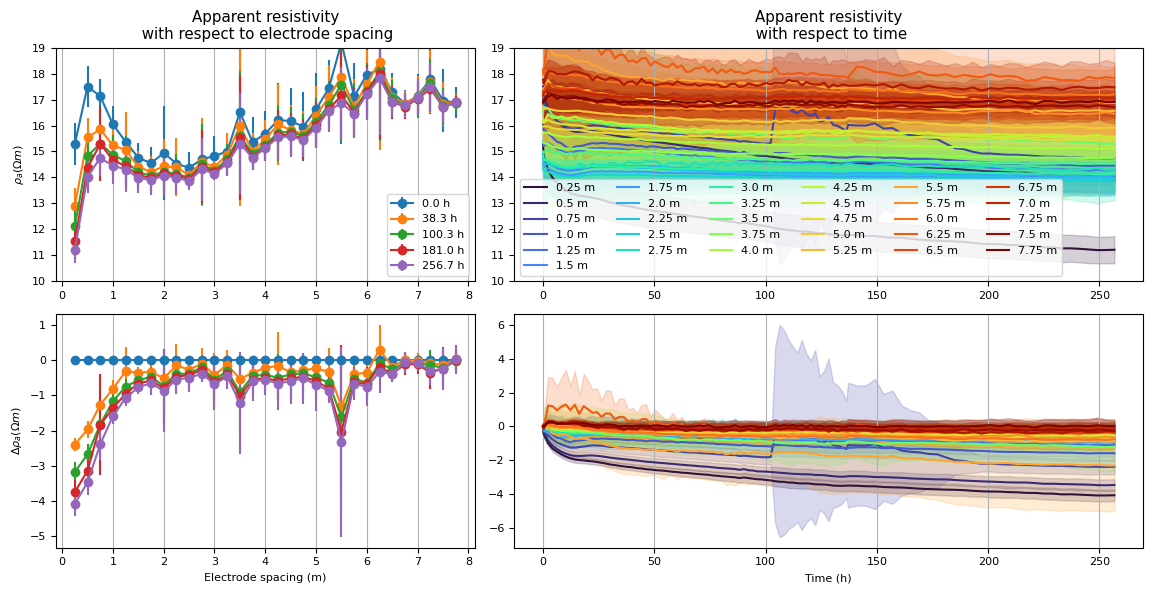

In [56]:
def plot_ert_data(data, spacing, avg, d_avg, std, d_std):
    fig, ax = plt.subplots(2, 2, figsize=(12, 6), width_ratios=[2, 3])
    
    dtime = np.unique(data['time (s)'])
    
    def add_to_axe(time):
        ax[0, 0].errorbar(spacing, avg[time], yerr=std[time], fmt='o-', label=f'{round(dtime[time]/3600, 1)} h')
        ax[1, 0].errorbar(spacing, d_avg[time], yerr=d_std[time], fmt='o-', label=f'{round(dtime[time]/3600, 1)} h')
        
    colors = plt.cm.turbo(np.linspace(0, 1, len(spacing)))
    for s, color in enumerate(colors):
        ax[0, 1].plot(dtime/3600, avg[:, s], '-', color=color, label=f'{spacing[s]} m')
        ax[0, 1].fill_between(dtime/3600, avg[:, s] - std[:, s], avg[:, s] + std[:, s], color=color, alpha=0.2)
        ax[1, 1].plot(dtime/3600, d_avg[:, s], '-', color=color)
        ax[1, 1].fill_between(dtime/3600, d_avg[:, s] - d_std[:, s], d_avg[:, s] + d_std[:, s], color=color, alpha=0.2)
    
    add_to_axe(0)
    add_to_axe(20)
    add_to_axe(50)
    add_to_axe(80)
    add_to_axe(99)
    
    for a in ax.flat:
        a.xaxis.grid(True)
    
    ax[0, 0].set_ylabel(r'$\rho_a (\Omega m)$')
    ax[0, 0].set_ylim(10, 19)
    ax[0, 1].set_ylim(10, 19)
    ax[0, 0].legend()
    ax[0, 1].legend(ncol=6)
    
    ax[1, 0].set_ylabel(r'$\Delta \rho_a (\Omega m)$')
    ax[0, 0].set_title('Apparent resistivity\n with respect to electrode spacing')
    ax[0, 1].set_title('Apparent resistivity\n with respect to time')
    
    ax[1, 0].set_xlabel('Electrode spacing (m)')
    ax[1, 1].set_xlabel('Time (h)')
    
    plt.tight_layout()
    
plot_ert_data(data_ert_heating, spacing, avg, d_avg, std, d_std)

## Filter faulty electrodes

Some electrode spacing have a greater standard deviation than others, suggesting either heterogeneity in the cable section or sensitivity to noise. Bigger electrode spacings (> 3 m) also show more variability, as the signal-to-noise ratio diminishes. To further investigate these phenomenons, we plot the resistivity values for each injection electrode. 

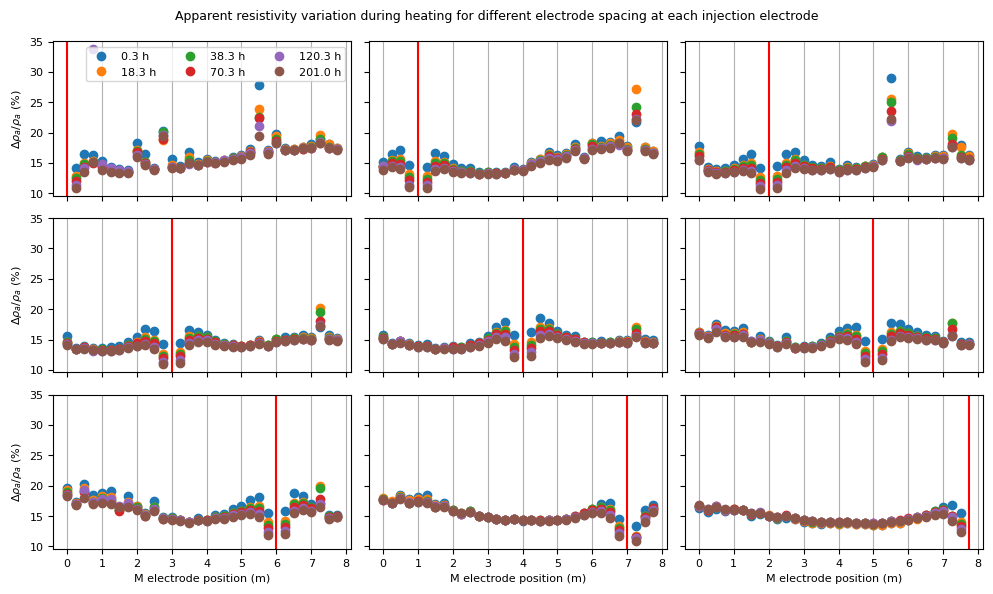

In [57]:
fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharex=True, sharey=True)  
plt.suptitle('Apparent resistivity variation during heating for different electrode spacing at each injection electrode')

def add_to_axe(axes, t, data=data_ert_heating):
    
    time = np.unique(data['time (s)'])

    axes[0, 0].plot(data[(data['position']==0) & (data['time (s)']==time[t])]['M(z)'],data[(data['position']==0) & (data['time (s)']==time[t])]['Rho-a(Ohm-m)'], 'o', label=f'{round(time[t]/3600, 1)} h')
    axes[0, 1].plot(data[(data['position']==1) & (data['time (s)']==time[t])]['M(z)'],data[(data['position']==1) & (data['time (s)']==time[t])]['Rho-a(Ohm-m)'], 'o', label=f'{round(time[t]/3600, 1)} h')
    axes[0, 2].plot(data[(data['position']==2) & (data['time (s)']==time[t])]['M(z)'],data[(data['position']==2) & (data['time (s)']==time[t])]['Rho-a(Ohm-m)'], 'o', label=f'{round(time[t]/3600, 1)} h')
    axes[1, 0].plot(data[(data['position']==3) & (data['time (s)']==time[t])]['M(z)'],data[(data['position']==3) & (data['time (s)']==time[t])]['Rho-a(Ohm-m)'], 'o', label=f'{round(time[t]/3600, 1)} h')
    axes[1, 1].plot(data[(data['position']==4) & (data['time (s)']==time[t])]['M(z)'],data[(data['position']==4) & (data['time (s)']==time[t])]['Rho-a(Ohm-m)'], 'o', label=f'{round(time[t]/3600, 1)} h')
    axes[1, 2].plot(data[(data['position']==5) & (data['time (s)']==time[t])]['M(z)'],data[(data['position']==5) & (data['time (s)']==time[t])]['Rho-a(Ohm-m)'], 'o', label=f'{round(time[t]/3600, 1)} h')
    axes[2, 0].plot(data[(data['position']==6) & (data['time (s)']==time[t])]['M(z)'],data[(data['position']==6) & (data['time (s)']==time[t])]['Rho-a(Ohm-m)'], 'o', label=f'{round(time[t]/3600, 1)} h')
    axes[2, 1].plot(data[(data['position']==7) & (data['time (s)']==time[t])]['M(z)'],data[(data['position']==7) & (data['time (s)']==time[t])]['Rho-a(Ohm-m)'], 'o', label=f'{round(time[t]/3600, 1)} h')
    axes[2, 2].plot(data[(data['position']==7.75) & (data['time (s)']==time[t])]['M(z)'],data[(data['position']==7.75) & (data['time (s)']==time[t])]['Rho-a(Ohm-m)'], 'o', label=f'{round(time[t]/3600, 1)} h')

add_to_axe(axes, 1)
add_to_axe(axes, 10)
add_to_axe(axes, 20)
add_to_axe(axes, 35)
add_to_axe(axes, 60)
add_to_axe(axes, 85)

axes[0, 0].axvline(x=0.0, color='r')
axes[0, 1].axvline(x=1.0, color='r')
axes[0, 2].axvline(x=2.0, color='r')
axes[1, 0].axvline(x=3.0, color='r')
axes[1, 1].axvline(x=4.0, color='r')
axes[1, 2].axvline(x=5.0, color='r')
axes[2, 0].axvline(x=6.0, color='r')
axes[2, 1].axvline(x=7.0, color='r')
axes[2, 2].axvline(x=7.75, color='r')

axes[0, 0].set_ylabel(r'$\Delta \rho_a/\rho_a$ (%)')
axes[1, 0].set_ylabel(r'$\Delta \rho_a/\rho_a$ (%)')
axes[2, 0].set_ylabel(r'$\Delta \rho_a/\rho_a$ (%)')
axes[2, 0].set_xlabel('M electrode position (m)')
axes[2, 1].set_xlabel('M electrode position (m)')
axes[2, 2].set_xlabel('M electrode position (m)')

axes[0, 0].legend(ncol=3)
#axes[0, 0].set_ylim(-30, 10)

plt.xticks(range(9))

for ax in axes.flat:
    ax.xaxis.grid(True)

plt.tight_layout()
plt.show()

Some electrodes, even when near the injection electrodes present erroneous apparent electrical resistivity values. These electrodes are removed from the dataset.

In [58]:
remove_e = [0, 1.75, 5.5, 6.75, 7, 7.25, 7.5, 7.75]
data_ert_heating_filtered = data_ert_heating[~data_ert_heating[['A(z)', 'M(z)']].isin(remove_e).any(axis=1)]
print('Removed electrodes : ', np.array(remove_e)/0.25+1)

Removed electrodes :  [ 1.  8. 23. 28. 29. 30. 31. 32.]


We recalculate the average apparent resistivity and its standard deviation after removing these electrodes.

/userdata/u/cszabosom/project/py38_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/u/cszabosom/project/py38_env/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/userdata/u/cszabosom/project/py38_env/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/userdata/u/cszabosom/project/py38_env/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/userdata/u/cszabosom/project/py38_env/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


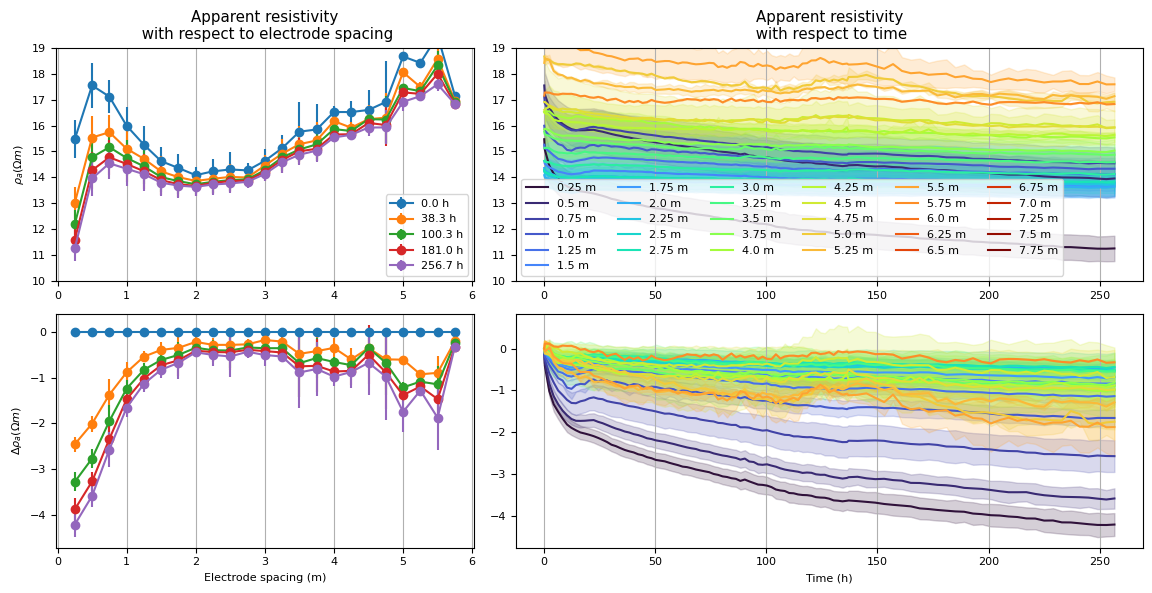

In [59]:
avg, d_avg, r_avg, std, d_std, r_std = get_average_ert(data_ert_heating_filtered, spacing)
plot_ert_data(data_ert_heating_filtered, spacing, avg, d_avg, std, d_std)

The standard deviation has decreased for most electrode spacings, indicating that the removed electrodes were indeed problematic. However, larger electrode spacings still show higher variability. Consequently, we only keep electrode spacings smaller than 2 m

In [60]:
data_ert_heating_filtered = data_ert_heating_filtered[~((abs(data_ert_heating_filtered['spacing (m)']) > 2))]
spacing = np.arange(0.25, 2 + 0.25, 0.25)

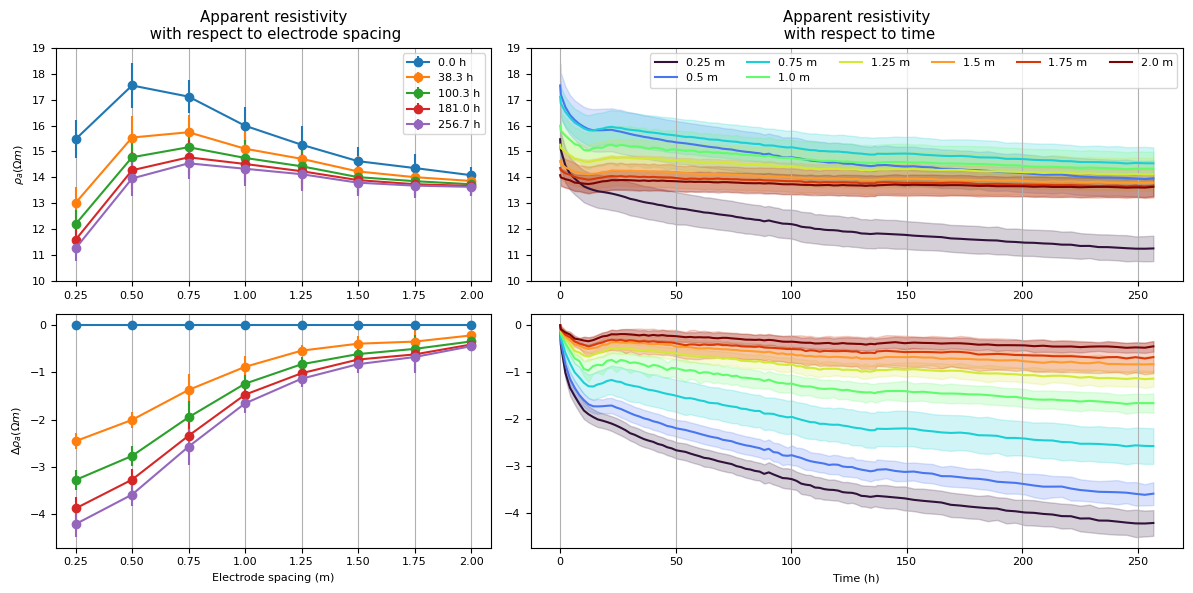

In [61]:
avg, d_avg, r_avg, std, d_std, r_std = get_average_ert(data_ert_heating_filtered, spacing)
plot_ert_data(data_ert_heating_filtered, spacing, avg, d_avg, std, d_std)

The ERT data filtering is satisfying. All electrodes spacings show a similar standard deviation and the latter is smaller than the apparent resistivity variation. We now create a summary dataframe with the average apparent resistivity and its standard deviation, as well as the variation and relative variation with respect to the reference measurement, along with their standard deviation.

In [62]:
def create_ERT_dataframe(data, spacing):
    average_data = []

    for i, t in enumerate(np.unique(data['time (s)'])):
        for j, dz in enumerate(spacing):
            # Subset data for the current time and spacing
            subset0 = data[(data['time (s)'] == 0) & (abs(data['spacing (m)']) == dz)]
            subset = data[(data['time (s)'] == t) & (abs(data['spacing (m)']) == dz)]
            
            if subset.empty or subset0.empty:
                continue
        
            # Extract values
            v0 = subset0['Rho-a(Ohm-m)'].values
            values = subset['Rho-a(Ohm-m)'].values
            
            # Compute statistics
            average = np.mean(values)
            std_dev = np.std(values)
            diff_avg = np.mean(values - v0)
            diff_std = np.std(values - v0)
            rel_avg = np.mean((values - v0) / v0) * 100
            rel_std = np.std((values - v0) / v0) * 100
            res = np.mean(abs(values - np.mean(values)))
            res_rel = np.mean(abs((values - v0) / v0 - np.mean((values - v0) / v0))) * 100
            

            average_data.append({
                'time (s)': t,
                'datetime' : subset['datetime'].iloc[0],
                'spacing (m)': dz,
                'avg Rho-a (Ohm-m)': average,
                'std Rho-a (Ohm-m)': std_dev,
                'avg dRho-a (Ohm-m)': diff_avg,
                'std dRho-a (Ohm-m)': diff_std,
                'rel avg (%)': rel_avg,
                'rel std (%)': rel_std,
                'residual': res,
                'rel residual (%)': res_rel
            })
            
    return pd.DataFrame(average_data)

In [63]:
data_average = create_ERT_dataframe(data_ert_heating_filtered, spacing)
print(data_average.head())
data_average.to_csv(os.path.join(dir_exp, 'data_ERT_heating.csv'), index=False)

   time (s)            datetime  spacing (m)  avg Rho-a (Ohm-m)  \
0         0 2024-10-17 16:30:00         0.25          15.471400   
1         0 2024-10-17 16:30:00         0.50          17.544790   
2         0 2024-10-17 16:30:00         0.75          17.115210   
3         0 2024-10-17 16:30:00         1.00          15.991590   
4         0 2024-10-17 16:30:00         1.25          15.259789   

   std Rho-a (Ohm-m)  avg dRho-a (Ohm-m)  std dRho-a (Ohm-m)  rel avg (%)  \
0           0.733359                 0.0                 0.0          0.0   
1           0.855139                 0.0                 0.0          0.0   
2           0.623671                 0.0                 0.0          0.0   
3           0.704630                 0.0                 0.0          0.0   
4           0.716825                 0.0                 0.0          0.0   

   rel std (%)  residual  rel residual (%)  
0          0.0  0.656400               0.0  
1          0.0  0.733966               0.0  

## Load full electrical dataset

Now that ERT data during heating has been filtered, we load the full dataset.

In [64]:
sub_all = ['VARENNES-H1710', 'VARENNES-H1810', 'VARENNES-H1910', 'VARENNES-H2010', 'VARENNES-H2110', 'VARENNES-H2210', 'VARENNES-H2310', 'VARENNES-H2410', 'VARENNES-H2510', 'VARENNES-H2610', 'VARENNES-H2710', 'VARENNES-H2810', 'VARENNES-B2810', 'VARENNES-B2910', 'VARENNES-B3010', 'VARENNES-R3010', 'VARENNES-R3110', 'VARENNES-R0111', 'VARENNES-R0211', 'VARENNES-R0311', 'VARENNES-R0411']

all_ert_files = files_in_dir(dir_ERT, sub_all)
print('Number of files:', len(all_ert_files))

all_ert_files = [file0] + all_ert_files

Number of files: 165


In [65]:
# extract data
data_ert_all = extract_ert_data(all_ert_files)

# remove faulty electrodes
data_ert_all = data_ert_all[~data_ert_all[['A(z)', 'M(z)']].isin(remove_e).any(axis=1)]

The ERT data can be plotted for the full duration of the experiment.

In [66]:
avg_full, d_avg_full, r_avg_full, std_full, d_std_full, r_std_full = get_average_ert(data_ert_all, spacing) 

/tmp/ipykernel_8393/4139639597.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(xtick_labels)


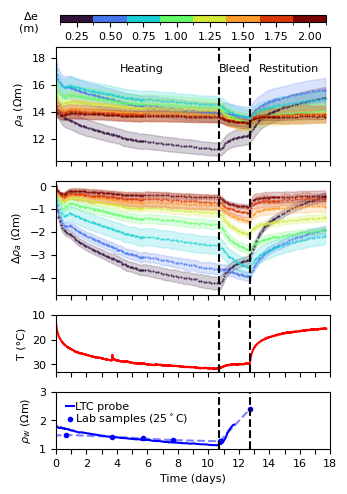

In [67]:
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(4, 1, figsize=(9/2.54, 13/2.54), sharex=True, height_ratios=[2, 2, 1, 1])

dtime = np.unique(data_ert_all['time (s)'])

colors = plt.cm.turbo(np.linspace(0, 1, len(spacing)))
for s, color in enumerate(colors):
    ax[0].plot(dtime/3600/24, avg_full[:, s], 'o', color=color, label=f'{spacing[s]}', markersize=0.5)
    ax[0].fill_between(dtime/3600/24, avg_full[:, s] - std_full[:, s], avg_full[:, s] + std_full[:, s], color=color, alpha=0.2)
    ax[1].plot(dtime/3600/24, d_avg_full[:, s], 'o', color=color, label=f'{spacing[s]}', markersize=0.5)
    ax[1].fill_between(dtime/3600/24, d_avg_full[:, s] - d_std_full[:, s], d_avg_full[:, s] + d_std_full[:, s], color=color, alpha=0.2)


ax[0].set_xlim(0, 18)
ax[0].text(dtime[50]/3600/24, 17, 'Heating', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1, 'edgecolor': 'white'}, fontsize=8)
ax[0].text(dtime[99]/3600/24, 17, 'Bleed', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1, 'edgecolor': 'white'}, fontsize=8)
ax[0].text(dtime[130]/3600/24, 17, 'Restitution', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 1, 'edgecolor': 'white'}, fontsize=8)
ax[0].set_ylabel(r'$\rho_a$ ($\Omega$m)')
ax[1].set_ylabel(r'$\Delta \rho_a$ ($\Omega$m)')

ax[2].plot(DTS_full['time (s)'] / 3600 / 24, DTS_full['temperature (degC)'], 'red', label='Fiber optic')
ax[2].set_ylabel('T (°C)')

ax[3].plot(data_LTC['time (s)']/ 3600 / 24, 1 / data_LTC['sigma_w (S/m)'], label='LTC probe', color='blue')
ax[3].plot(lab_cal['time (s)']/3600/24, 1 / lab_cal['sigma_w (S/m)'], 'o', label='Lab samples (25$^\circ$C)', color='blue', markersize=3)
ax[3].plot(lab_cal['time (s)']/3600/24, 1 / lab_cal['sigma_w (S/m)'], '--', color='blue', alpha=0.5)

ax[3].set_ylabel(r'$\rho_w$ ($\Omega$m)')
ax[3].set_xlabel('Time (days)')
ax[3].set_ylim(1, 3)
ax[3].legend(loc='upper left', fontsize=8, frameon=False, ncol=1, handlelength=0.7, handletextpad=0.1, labelspacing=0.1)

ax[2].set_ylim(33, 10)

xticks = np.arange(0, 19, 1)
xtick_labels = [str(x) if x % 2 == 0 else '' for x in xticks]
ax[3].set_xticklabels(xtick_labels)

for a in ax:
    a.axvline(x=dtime[99]/3600/24, color='black', linestyle='--')
    a.axvline(x=dtime[123]/3600/24, color='black', linestyle='--')
    a.set_xticks(np.arange(0, 19, 1))
    a.tick_params(axis='both', which='major')

plt.tight_layout()

fig.subplots_adjust(top=0.88)

cmap = mcolors.ListedColormap(colors)
bounds = np.append(spacing - 0.125, spacing[-1] + 0.125)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.18, 0.93, 0.75, 0.012])
cb = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=spacing)
fig.text(0.12, 0.93, '$\Delta$e \n(m)', va='center', ha='right', fontsize=8, rotation=0, color='black')

plt.show()

The complete ERT dataset is saved for future use.

In [68]:
data_average_all = create_ERT_dataframe(data_ert_all, spacing)
print(data_average_all.head())
data_average.to_csv(os.path.join(dir_exp, 'data_ERT_all.csv'), index=False)

   time (s)            datetime  spacing (m)  avg Rho-a (Ohm-m)  \
0         0 2024-10-17 16:30:00         0.25          15.471400   
1         0 2024-10-17 16:30:00         0.50          17.544790   
2         0 2024-10-17 16:30:00         0.75          17.115210   
3         0 2024-10-17 16:30:00         1.00          15.991590   
4         0 2024-10-17 16:30:00         1.25          15.259789   

   std Rho-a (Ohm-m)  avg dRho-a (Ohm-m)  std dRho-a (Ohm-m)  rel avg (%)  \
0           0.733359                 0.0                 0.0          0.0   
1           0.855139                 0.0                 0.0          0.0   
2           0.623671                 0.0                 0.0          0.0   
3           0.704630                 0.0                 0.0          0.0   
4           0.716825                 0.0                 0.0          0.0   

   rel std (%)  residual  rel residual (%)  
0          0.0  0.656400               0.0  
1          0.0  0.733966               0.0  

## Reciprocal error

The relative reciprocal error is given by the following formula:

$$
e_R = \frac{|R_{direct} - R_{reciprocal}|}{\frac{R_{direct} + R_{reciprocal}}{2}}
$$

In this experiment, we have two types of reciprocal errors :
1- The reciprocals already present in the standard Pole-Pole measurement sequence (about 50 pairs)
2- The complete reciprocals, where a full reciprocal protocol was run at the 4 key phases of the experiment (heating, bleed, restitution, reference)

We start with type 1, where we use the whole ERT dataset. First, the index of the reciprocal pairs must be found.

In [69]:
t0 = '1630'
d0 = 17

columns = ['A(z)', 'B(z)', 'N(z)', 'M(z)', 'U(V)', 'R(Ohm)',  'Rho-a(Ohm-m)', 'Var(%)', 'Time']

def reciprocal_data(files, A, M):
    # time x electrode
    direct = pd.DataFrame()
    reciprocal = pd.DataFrame()
    df0 = extract_columns(ert_files[0])

    for i, file in enumerate(files):
        df = extract_columns(file)
    
        df['Rhoa/Rhoa0'] = df['Rho-a(Ohm-m)'] / df0['Rho-a(Ohm-m)']
        
        add_direct = df.loc[A]
        add_reciprocal = df.loc[M]

        direct = pd.concat([direct, add_direct]).reset_index(drop=True)
        reciprocal = pd.concat([reciprocal, add_reciprocal]).reset_index(drop=True)

    return direct, reciprocal

In [70]:
A = []
M = [] 
pairs = set()
d0 = extract_columns(file0) 
d0 = d0[~d0[['A(z)', 'M(z)']].isin(remove_e).any(axis=1)]

for a in a_electrodes:

    current = d0[d0['A(z)'] == a] 

    # iterate through the potential electrodes
    for m in current['M(z)'].to_numpy():
        reciprocal = d0[(d0['A(z)'] == m) & (d0['M(z)'] == a)] 

        # If the reciprocal measurement exists
        if not reciprocal.empty:
            pair = (a, m)
            reciprocal_pair = (m, a)

            # Verify if the reciprocal has not been added yet
            if reciprocal_pair not in pairs:
                direct = d0[(d0['A(z)'] == a) & (d0['M(z)'] == m)]
                
                # Verify if the direct measurement exists
                if not direct.empty:
                    A.extend(direct.index.tolist()[:1])
                    M.extend(reciprocal.index.tolist())
                    pairs.add(pair)
                    pairs.add(reciprocal_pair)

reciprocal1, r = reciprocal_data(all_ert_files, A, M)

error1 = np.abs((reciprocal1['R(Ohm)'] - r['R(Ohm)'])/((reciprocal1['R(Ohm)'] + r['R(Ohm)'])/2))
reciprocal1['error_R'] = error1

In [71]:
print('Average reciprocal error :', np.mean(np.average(abs(error1), axis=0))*100, '%')
print('Maximum reciprocal error :', np.max(abs(error1), axis=0)*100, '%')

Average reciprocal error : 1.5690637961345393 %
Maximum reciprocal error : 66.03001874768462 %


The reciprocals are visualized with a histogram.

Text(0, 0.5, 'Frequency')

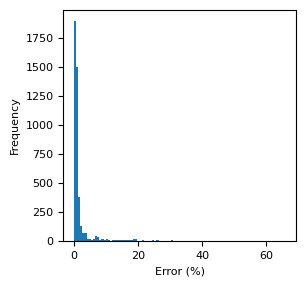

In [72]:
plt.figure(figsize=(3, 3))
plt.hist(reciprocal1['error_R']*100, bins=100)
plt.xlabel('Error (%)')
plt.ylabel('Frequency')

Now we look at the complete reciprocal measurements (type 2). We extract the files corresponding to the Pole-Pole reciprocal measurements.

In [73]:
files_reciprocal = files_in_dir(dir_ERT, ['VARENNES-B3010','VARENNES-C1710', 'VARENNES-R0411', 'VARENNES-H2810'], 'Polepole')
print('Number of files:', len(files_reciprocal))

Number of files: 4


In [74]:
# Find reciprocal data for each position
reciprocal2 = []

for i, file in enumerate(files_reciprocal):
    
    # Extract data in function of geometry
    pph = filter_ERT_data(file)
    all_data = extract_columns(file)
    
    # For each position, create a row for each measurement
    for position_id in a_electrodes:
        if not pph[str(position_id)].empty:
            pos = pph[str(position_id)]
            reciprocal_data = []
            for r in range(len(pos)):
                A = pos['A(z)'].iloc[r]
                M = pos['M(z)'].iloc[r]
                reciprocal_data.append(all_data[(all_data['A(z)'] == M) & (all_data['M(z)'] == A)])

            # Create a row for each measurement at this position
            for idx in range(len(pos)):
                row_data = {
                    'time D':  pd.to_datetime(pos['Time'].iloc[idx]),
                    'time R':  pd.to_datetime(reciprocal_data[idx]['Time'].iloc[0]),
                    'dtime (s)' :  abs(pd.to_datetime(reciprocal_data[idx]['Time'].iloc[0]) -  pd.to_datetime(pos['Time'].iloc[idx])).total_seconds(),
                    'position': position_id,
                    'spacing (m)' : pos['M(z)'].iloc[idx] - position_id,
                    'reciprocal rhoa': float(reciprocal_data[idx]['R(Ohm)']),
                    'error R (abs)': float(abs(pos['R(Ohm)'].iloc[idx] - reciprocal_data[idx]['R(Ohm)'])),
                    'error R (%)' : float(abs(pos['R(Ohm)'].iloc[idx] - reciprocal_data[idx]['R(Ohm)'])/((pos['R(Ohm)'].iloc[idx] + reciprocal_data[idx]['R(Ohm)'])/2)*100)
                }
                
                for column in pos.columns:
                    row_data[column] = pos[column].iloc[idx]
                    
                reciprocal2.append(row_data)
        else:
            print(f"Empty data for position {position_id} in file {file}")

# Create final DataFrame
reciprocal2 = pd.DataFrame(reciprocal2)

/tmp/ipykernel_8393/704347776.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'reciprocal rhoa': float(reciprocal_data[idx]['R(Ohm)']),
/tmp/ipykernel_8393/704347776.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'error R (abs)': float(abs(pos['R(Ohm)'].iloc[idx] - reciprocal_data[idx]['R(Ohm)'])),
/tmp/ipykernel_8393/704347776.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'error R (%)' : float(abs(pos['R(Ohm)'].iloc[idx] - reciprocal_data[idx]['R(Ohm)'])/((pos['R(Ohm)'].iloc[idx] + reciprocal_data[idx]['R(Ohm)'])/2)*100)
/tmp/ipykernel_8393/704347776.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

In [75]:
reciprocal = pd.concat([reciprocal1, reciprocal2], ignore_index=True)

All reciprocals are visualized for each electrode spacing.

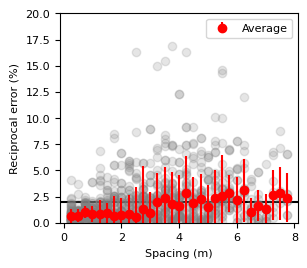

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(8/2.54, 7/2.54))

ax.axhline(2, color='k')

# Scatter all raw points, but with absolute spacing
plt.plot(abs(reciprocal['spacing (m)']), reciprocal['error R (%)'], 'o', color='grey', alpha=0.2)

# Group by absolute spacing
spacing_groups = reciprocal.groupby(abs(reciprocal['spacing (m)']))['error R (%)'].agg(['median', 'std']).reset_index()

# Plot median + error bars
plt.errorbar(spacing_groups['spacing (m)'], spacing_groups['median'],
             yerr=spacing_groups['std'], fmt='o', color='red',
             label='Average')

plt.ylim(0, 20)
ax.set_ylabel('Reciprocal error (%)')
ax.set_xlabel('Spacing (m)')
plt.legend()

plt.tight_layout()

plt.show()

For electrode spacings smaller than 2 m, all reciprocals are visualized with a histogram to obtain the reciprocal error distribution.

In [77]:
reciprocal_2m = reciprocal[abs(reciprocal['A(z)']-reciprocal['M(z)'])<2.1]

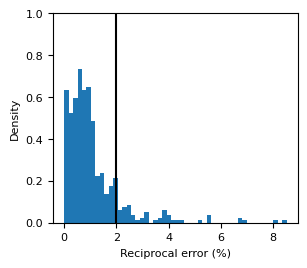

In [78]:
reciprocal_error = 0.02

plt.figure(figsize=(8/2.54, 7/2.54))

plt.hist(reciprocal_2m['error R (%)'], bins=50, density=True)
plt.xlabel('Reciprocal error (%)')
plt.ylabel('Density')
plt.ylim(0, 1)
plt.axvline(reciprocal_error*100, color='k')
plt.tight_layout()

We use a conservative reciprocal error of :

In [79]:
print('Reciprocal error (%) :', reciprocal_error*100)

Reciprocal error (%) : 2.0


The average error during the heating phase is obtained with the following equation :

$$
  \sigma_\rho = \frac{1}{N_e} \sum_{i=1}^{N_e} \left( \frac{1}{\sqrt{N_{\rho,i}}}\frac{|e|}{N_tN_{\rho,i}} \sum_{j=1}^{N_{\rho,i}} \rho_{a,ij} \right),
$$

where a $|e|$ is the reciprocal error, $N_t$ the number of timesteps, $N_\rho$ is the number of duplicates and $N_e$ is the number of electrode spacing. 

In [80]:
avg, d_avg, r_avg, std, d_std, r_std, duplicates = get_average_ert(data_ert_heating_filtered, spacing, return_duplicates=True)

sigma_ert = np.mean(1/np.sqrt(duplicates) * reciprocal_error * np.mean(np.abs(avg), 0))
print('ERT measurement error during heating :', np.round(sigma_ert, 3), 'Ohm m')

ERT measurement error during heating : 0.092 Ohm m
